# Define Running Mode

- 'full_dataset = True' to use the full data set. If 'full_dataset = True', then a data set containing only data one year of the hobbies sales in TX2.  
    
- 'submit_to_kaggle = True' to submit the forecasts to Kaggle.  


In [1]:
full_dataset = True
submit_to_kaggle = False


# Import Packages

In [2]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# Data Import and Preparation

In [3]:
if full_dataset:
    prefix = 'full_dataset'
else:
    prefix = 'subset'

df_merged = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/feature_engineering/{prefix}_df_merged.csv')

scaling_factors_rmsse = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/weights/scaling_factors_rmsse.csv')

weights_wrmsse = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/weights/weights_for_wrmsse.csv')


In [4]:
# downcast numerical values to reduce mem usage
df_merged = utils.reduce_mem_usage(df_merged)

Mem. usage of decreased to 4912.94 Mb (64.7% reduction)


# Delete Data where Item was not up for Sale

Item is not up for sale when price is NA.

In [5]:
print(df_merged.shape)

df_merged = df_merged.loc[df_merged['sell_price'] > 0]

print(df_merged.shape)

(53662400, 34)
(44307636, 34)


# Model Training & Forecasting (LightGBM)

In [6]:
# Custom Loss & valid for asymetric rmse
def custom_mse_asymmetric_loss(y_pred, y_true):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual < 0, -2 * residual, -2 * residual * 1.1)
    hess = np.where(residual < 0, 2, 2 * 1.1)
    return grad, hess


def custom_rmse_asymmetric_valid(y_pred, y_true, tmp=None):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual < 0, (residual ** 2), (residual ** 2) * 1.1)
    return "custom_mse_asymmetric_eval", np.sqrt(np.mean(loss)), False

In [7]:
# TODO: proper feature selection (e.g. random forrest)
# for now: hardcoded list of features

cat_features = [
    'item_id',
    'dept_id',
    'cat_id',
    'store_id',
    'state_id',
    'year',
    'month',
    'day',
    'is_weekend',
    'wday',
    'event_name_1',
    'event_type_1',
    'event_name_2',
    'event_type_2',
    'snap_CA',
    'snap_TX',
    'snap_WI',
    'up_for_sale'
]

num_features = [
    'sell_price',
    'lag_t28',
    'rolling_kurt_t28',
    'rolling_skew_t28',
    'rolling_mean_t28',
    'rolling_std_t28',
    'price_change_t1',
    'price_change_t30',
    'rolling_price_std_t28',
]

features = cat_features + num_features

In [42]:


params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'seed': 10,
    'learning_rate': 0.15,
    'bagging_fraction': 0.75,
    'bagging_freq': 10,
    'max_bin': 128,
    'feature_fraction ': 0.75,
}

evals_result = {}  # to record eval results for plotting


for cat in df_merged.cat_id.drop_duplicates():
    
    print('\n ***** Computation for cat_id ', cat, '*****')
    
    print('log: create data sets')
    x_train = df_merged[df_merged['date'] <= '2016-03-27'].loc[df_merged['cat_id'] == cat][features]
    y_train = df_merged[df_merged['date'] <= '2016-03-27'].loc[df_merged['cat_id'] == cat]['sale']

    x_val = df_merged.loc[df_merged['data_type'] ==
                          'train'].loc[df_merged['date'] > '2016-03-27'].loc[df_merged['cat_id'] == cat][features]
    y_val = df_merged.loc[df_merged['data_type'] ==
                          'train'].loc[df_merged['date'] > '2016-03-27'].loc[df_merged['cat_id'] == cat]['sale']

    print('log: create LightGBM data sets')
    train_data = lgb.Dataset(x_train, label=y_train,
                             categorical_feature=cat_features, free_raw_data=False,
                           )
    validation_data = lgb.Dataset(
        x_val, label=y_val, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
    )

    print('log: model training')
    gbm= lgb.train(params, train_data, valid_sets=[train_data, validation_data],
                    evals_result=evals_result, num_boost_round=1000,
                    verbose_eval=25, early_stopping_rounds=20,
                    fobj=custom_mse_asymmetric_loss,
                    feval=custom_rmse_asymmetric_valid
                   )
    
    print('log: save model')
    gbm.save_model(f'gbm_cat_id_{cat}.txt', num_iteration=gbm.best_iteration) 



 ***** Computation for cat_id  1 *****
log: create data sets
log: create LightGBM data sets
log: model training
Training until validation scores don't improve for 20 rounds
[25]	training's custom_mse_asymmetric_eval: 1.84483	valid_1's custom_mse_asymmetric_eval: 1.72891
[50]	training's custom_mse_asymmetric_eval: 1.82727	valid_1's custom_mse_asymmetric_eval: 1.7272
Early stopping, best iteration is:
[50]	training's custom_mse_asymmetric_eval: 1.82727	valid_1's custom_mse_asymmetric_eval: 1.7272
log: save model

 ***** Computation for cat_id  2 *****
log: create data sets
log: create LightGBM data sets
log: model training
Training until validation scores don't improve for 20 rounds
[25]	training's custom_mse_asymmetric_eval: 1.62596	valid_1's custom_mse_asymmetric_eval: 1.52345
[50]	training's custom_mse_asymmetric_eval: 1.59686	valid_1's custom_mse_asymmetric_eval: 1.51675
[75]	training's custom_mse_asymmetric_eval: 1.58096	valid_1's custom_mse_asymmetric_eval: 1.51242
[100]	training'

In [143]:

# keep date here, drop later
x_pred = df_merged[(df_merged['data_type'] == 'validation')][features]
x_pred['y_pred'] = np.nan


for cat in x_pred.cat_id.drop_duplicates():
    mod = lgb.Booster(model_file=f'gbm_cat_id_{cat}.txt')
    x_pred.loc[x_pred.cat_id == cat,'y_pred'] = mod.predict(x_pred.loc[x_pred.cat_id == cat][features])
    

    

,item_id,dept_id,cat_id,store_id,state_id,year,month,day,is_weekend,wday,...,up_for_sale,sell_price,lag_t28,rolling_kurt_t28,rolling_skew_t28,rolling_mean_t28,rolling_std_t28,price_change_t1,price_change_t30,rolling_price_std_t28
52808680,1437,3,1,0,0,2016,4,25,0,3,...,1,8.38,1.0,0.246603,0.763245,1.033333,0.927858,0.0,0.0,5.968164e-02
52808681,1438,3,1,0,0,2016,4,25,0,3,...,1,3.97,1.0,-1.731692,0.744880,0.333333,0.479463,0.0,0.0,0.000000e+00
52808682,1439,3,1,0,0,2016,4,25,0,3,...,1,2.97,0.0,16.585960,3.904594,0.500000,1.167077,0.0,0.0,0.000000e+00
52808683,1440,3,1,0,0,2016,4,25,0,3,...,1,4.64,0.0,-0.529831,0.790924,1.966667,2.075860,0.0,0.0,0.000000e+00
52808684,1441,3,1,0,0,2016,4,25,0,3,...,1,2.88,1.0,-0.717982,0.542001,1.100000,0.959526,0.0,0.0,4.434852e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53662395,1432,2,0,9,2,2016,5,22,1,2,...,1,2.98,1.0,6.029183,2.758372,0.200000,0.550861,0.0,0.0,7.810822e-08
53662396,1433,2,0,9,2,2016,5,22,1,2,...,1,2.48,0.0,1.580669,1.621490,0.300000,0.534983,0.0,0.0,4.964984e-08
53662397,1434,2,0,9,2,2016,5,22,1,2,...,1,3.98,0.0,1.720479,1.485839,0.866667,1.136642,0.0,0.0,0.000000e+00
53662398,1435,2,0,9,2,2016,5,22,1,2,...,1,1.28,3.0,-0.140881,0.963120,1.066667,1.172481,0.0,0.0,0.000000e+00


# Training Analysis


 ***** Computation for cat_id  1 *****


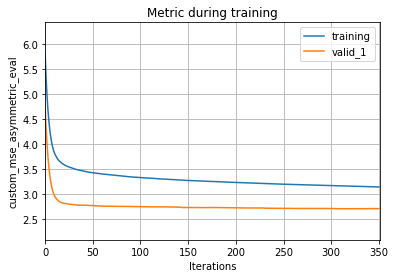

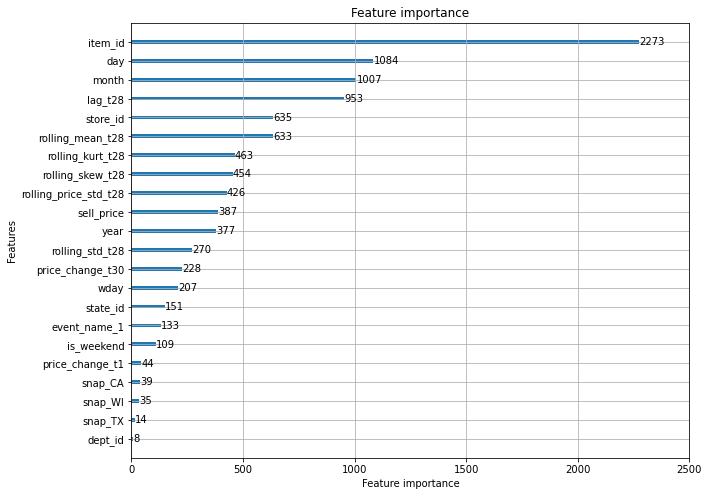


 ***** Computation for cat_id  2 *****


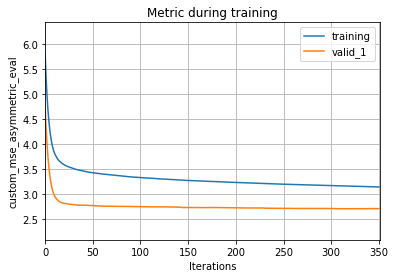

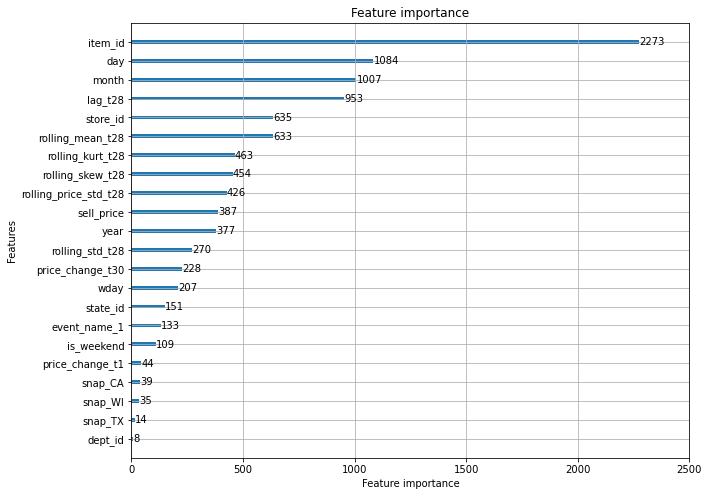


 ***** Computation for cat_id  0 *****


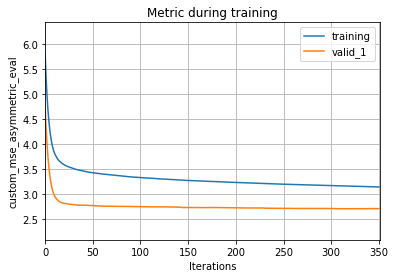

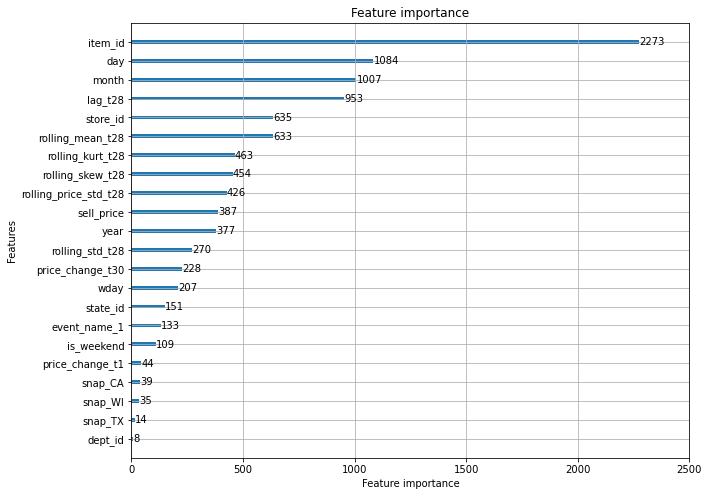

In [141]:
for cat in x_pred.cat_id.drop_duplicates():
    
    print('\n ***** Computation for cat_id ', cat, '*****')
    
    mod = lgb.Booster(model_file=f'gbm_cat_id_{cat}.txt')
    
    ax = lgb.plot_metric(evals_result)
    plt.show()
    
    ax = lgb.plot_importance(gbm, figsize=(10,8))
    plt.show()

# Compute RMSSE and WRMSSE on Validation Data

In [121]:
# compute forecasts, error and map it to df_merged to get ids
df_tmp = x_val.copy()

for cat in df_tmp.cat_id.drop_duplicates():
    mod = lgb.Booster(model_file=f'gbm_cat_id_{cat}.txt')
    df_tmp.loc[df_tmp.cat_id == cat,'y_pred'] = mod.predict(df_tmp.loc[df_tmp.cat_id == cat][features])
    
df_tmp['y_true'] = y_val
df_tmp['error'] = (df_tmp.y_true - df_tmp.y_pred)
df_tmp = df_tmp.merge(df_merged[['id', 'item_id','dept_id','cat_id', 'store_id', 'state_id']].drop_duplicates())

df_tmp

,item_id,dept_id,cat_id,store_id,state_id,year,month,day,is_weekend,wday,...,rolling_skew_t28,rolling_mean_t28,rolling_std_t28,price_change_t1,price_change_t30,rolling_price_std_t28,y_pred,y_true,error,id
0,0,0,0,0,0,2016,3,28,0,3,...,0.773966,0.766667,0.935261,0.0,0.0,0.0,0.748186,2.0,1.251814,FOODS_1_001_CA_1_validation
1,0,0,0,0,0,2016,3,29,0,4,...,0.947934,0.700000,0.915386,0.0,0.0,0.0,0.553540,1.0,0.446460,FOODS_1_001_CA_1_validation
2,0,0,0,0,0,2016,3,30,0,5,...,0.874017,0.733333,0.907187,0.0,0.0,0.0,0.591978,1.0,0.408022,FOODS_1_001_CA_1_validation
3,0,0,0,0,0,2016,3,31,0,6,...,1.057446,0.666667,0.884087,0.0,0.0,0.0,0.592484,0.0,-0.592484,FOODS_1_001_CA_1_validation
4,0,0,0,0,0,2016,4,1,0,7,...,1.057446,0.666667,0.884087,0.0,0.0,0.0,0.670046,4.0,3.329954,FOODS_1_001_CA_1_validation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402355,1436,2,0,9,2,2016,4,20,0,5,...,0.432608,1.766667,1.715715,0.0,0.0,0.0,2.208209,0.0,-2.208209,FOODS_3_827_WI_3_validation
402356,1436,2,0,9,2,2016,4,21,0,6,...,0.432608,1.766667,1.715715,0.0,0.0,0.0,2.100274,0.0,-2.100274,FOODS_3_827_WI_3_validation
402357,1436,2,0,9,2,2016,4,22,0,7,...,0.373565,1.833333,1.683251,0.0,0.0,0.0,2.542268,0.0,-2.542268,FOODS_3_827_WI_3_validation
402358,1436,2,0,9,2,2016,4,23,1,1,...,0.373565,1.833333,1.683251,0.0,0.0,0.0,2.706337,0.0,-2.706337,FOODS_3_827_WI_3_validation


In [122]:
# compute RMSSE and store it in dict
rmsse_dict = {}

for name, group in df_tmp.groupby(['id']):
    
    scale = scaling_factors_rmsse.loc[scaling_factors_rmsse['id'] == name]['scaling_factor'].to_list()[0]
    weight = weights_wrmsse.loc[weights_wrmsse['id'] == name]['weights'].values[0]
    
    rmsse_dict[name] = [np.sqrt(np.mean(group.error**2 / scale))]
    

In [123]:
# convert dict to dataframe
rmsse_df = pd.DataFrame(rmsse_dict).T
rmsse_df['id'] = rmsse_df.index
rmsse_df = rmsse_df.reset_index(drop=True)
rmsse_df = rmsse_df.rename(columns={0:'RMSSE'})

# add weights to df and compute weights multiplied by RMSSE
rmsse_df = rmsse_df.merge(weights_wrmsse, how='inner')
rmsse_df['w_times_RMSSE'] = rmsse_df.loc[:,'weights'] * rmsse_df.loc[:,'RMSSE']

# sort values by their impact
rmsse_df = rmsse_df.sort_values(by='RMSSE', ascending=False)


In [124]:
# compute WRMSSE
print('WRMSSE = %0.5f' % np.sum(rmsse_df.RMSSE * rmsse_df.weights))
# WRMSSE = 0.01167

WRMSSE = 0.50886


In [125]:
# show RMSSE and corresponding weights
rmsse_df.head(25).sort_values(by='w_times_RMSSE', ascending=False)

,RMSSE,id,weights,w_times_RMSSE
2288,3.412977,FOODS_2_013_WI_2_validation,0.000489,0.001669
3958,3.025669,FOODS_2_181_WI_2_validation,0.000474,0.001435
13668,4.702693,FOODS_3_757_WI_2_validation,0.000293,0.001379
5858,3.376656,FOODS_2_371_WI_2_validation,0.000328,0.001106
10348,3.236425,FOODS_3_422_WI_2_validation,0.000273,0.000885
6718,2.946959,FOODS_3_059_WI_2_validation,0.000264,0.000779
12148,3.678234,FOODS_3_602_WI_2_validation,0.000167,0.000615
7596,3.347470,FOODS_3_147_TX_3_validation,0.000157,0.000527
7595,2.935612,FOODS_3_147_TX_2_validation,0.000177,0.000518
12726,4.101527,FOODS_3_660_TX_3_validation,0.000124,0.000507


In [126]:
# analyse time series with max. RMSSE
df_tmp.loc[df_tmp.id == rmsse_df.loc[0,'id']][['id', 'month', 'day','up_for_sale','event_name_1', 'event_type_1',
       'event_name_2', 'event_type_2','is_weekend','wday', 'sell_price', 'y_pred', 'y_true', 'error',]]

,id,month,day,up_for_sale,event_name_1,event_type_1,event_name_2,event_type_2,is_weekend,wday,sell_price,y_pred,y_true,error
0,FOODS_1_001_CA_1_validation,3,28,1,13,1,3,1,0,3,2.24,0.748186,2.0,1.251814
1,FOODS_1_001_CA_1_validation,3,29,1,13,1,3,1,0,4,2.24,0.553540,1.0,0.446460
2,FOODS_1_001_CA_1_validation,3,30,1,13,1,3,1,0,5,2.24,0.591978,1.0,0.408022
3,FOODS_1_001_CA_1_validation,3,31,1,13,1,3,1,0,6,2.24,0.592484,0.0,-0.592484
4,FOODS_1_001_CA_1_validation,4,1,1,13,1,3,1,0,7,2.24,0.670046,4.0,3.329954
5,FOODS_1_001_CA_1_validation,4,2,1,13,1,3,1,1,1,2.24,0.942166,0.0,-0.942166
6,FOODS_1_001_CA_1_validation,4,3,1,13,1,3,1,1,2,2.24,0.822240,0.0,-0.822240
7,FOODS_1_001_CA_1_validation,4,4,1,13,1,3,1,0,3,2.24,0.503957,4.0,3.496043
8,FOODS_1_001_CA_1_validation,4,5,1,13,1,3,1,0,4,2.24,0.504620,1.0,0.495380
9,FOODS_1_001_CA_1_validation,4,6,1,13,1,3,1,0,5,2.24,0.516971,3.0,2.483029


In [127]:
# analyse time series (manually)
rel_id = 'FOODS_2_181_WI_2_validation'
df_tmp.loc[df_tmp.id == rel_id][['id', 'month', 'day','up_for_sale','event_name_1', 'event_type_1',
       'event_name_2', 'event_type_2','is_weekend','wday', 'sell_price', 'y_pred', 'y_true', 'error',]]

,id,month,day,up_for_sale,event_name_1,event_type_1,event_name_2,event_type_2,is_weekend,wday,sell_price,y_pred,y_true,error
332948,FOODS_2_181_WI_2_validation,3,28,1,13,1,3,1,0,3,1.78,15.292413,25.0,9.707587
332949,FOODS_2_181_WI_2_validation,3,29,1,13,1,3,1,0,4,1.78,14.698837,31.0,16.301163
332950,FOODS_2_181_WI_2_validation,3,30,1,13,1,3,1,0,5,1.78,15.078653,20.0,4.921347
332951,FOODS_2_181_WI_2_validation,3,31,1,13,1,3,1,0,6,1.78,18.388526,26.0,7.611474
332952,FOODS_2_181_WI_2_validation,4,1,1,13,1,3,1,0,7,1.78,20.634790,45.0,24.365210
332953,FOODS_2_181_WI_2_validation,4,2,1,13,1,3,1,1,1,1.78,30.298299,53.0,22.701701
332954,FOODS_2_181_WI_2_validation,4,3,1,13,1,3,1,1,2,1.78,28.995408,63.0,34.004592
332955,FOODS_2_181_WI_2_validation,4,4,1,13,1,3,1,0,3,1.78,18.928224,36.0,17.071776
332956,FOODS_2_181_WI_2_validation,4,5,1,13,1,3,1,0,4,1.78,27.045926,60.0,32.954074
332957,FOODS_2_181_WI_2_validation,4,6,1,13,1,3,1,0,5,1.78,24.681295,54.0,29.318705


# Printout Forecasts

In [129]:
x_pred

,item_id,dept_id,cat_id,store_id,state_id,year,month,day,is_weekend,wday,...,sell_price,lag_t28,rolling_kurt_t28,rolling_skew_t28,rolling_mean_t28,rolling_std_t28,price_change_t1,price_change_t30,rolling_price_std_t28,y_pred
52808680,1437,3,1,0,0,2016,4,25,0,3,...,8.38,1.0,0.246603,0.763245,1.033333,0.927858,0.0,0.0,5.968164e-02,0.901898
52808681,1438,3,1,0,0,2016,4,25,0,3,...,3.97,1.0,-1.731692,0.744880,0.333333,0.479463,0.0,0.0,0.000000e+00,0.325813
52808682,1439,3,1,0,0,2016,4,25,0,3,...,2.97,0.0,16.585960,3.904594,0.500000,1.167077,0.0,0.0,0.000000e+00,0.457246
52808683,1440,3,1,0,0,2016,4,25,0,3,...,4.64,0.0,-0.529831,0.790924,1.966667,2.075860,0.0,0.0,0.000000e+00,1.782622
52808684,1441,3,1,0,0,2016,4,25,0,3,...,2.88,1.0,-0.717982,0.542001,1.100000,0.959526,0.0,0.0,4.434852e-08,0.984492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53662395,1432,2,0,9,2,2016,5,22,1,2,...,2.98,1.0,6.029183,2.758372,0.200000,0.550861,0.0,0.0,7.810822e-08,0.460277
53662396,1433,2,0,9,2,2016,5,22,1,2,...,2.48,0.0,1.580669,1.621490,0.300000,0.534983,0.0,0.0,4.964984e-08,0.354068
53662397,1434,2,0,9,2,2016,5,22,1,2,...,3.98,0.0,1.720479,1.485839,0.866667,1.136642,0.0,0.0,0.000000e+00,0.862780
53662398,1435,2,0,9,2,2016,5,22,1,2,...,1.28,3.0,-0.140881,0.963120,1.066667,1.172481,0.0,0.0,0.000000e+00,1.474251


In [130]:
# map encoded ids to decoded ids
id_mapping_table = df_merged[['id', 'item_id', 'year', 'month', 'day','store_id']].drop_duplicates()
df_results = x_pred.merge(id_mapping_table,
                         on=['item_id', 'store_id', 'year', 'month', 'day'],
                         how='left')[[
                             'id', 'item_id', 'store_id', 'year', 'month',
                             'day', 'y_pred'
                         ]]

In [131]:
id_mapping_table

,id,item_id,year,month,day,store_id
1,HOBBIES_1_002_CA_1_validation,1438,2011,7,29,0
3,HOBBIES_1_004_CA_1_validation,1440,2011,7,29,0
4,HOBBIES_1_005_CA_1_validation,1441,2011,7,29,0
7,HOBBIES_1_008_CA_1_validation,1444,2011,7,29,0
8,HOBBIES_1_009_CA_1_validation,1445,2011,7,29,0
...,...,...,...,...,...,...
53662395,FOODS_3_823_WI_3_validation,1432,2016,5,22,9
53662396,FOODS_3_824_WI_3_validation,1433,2016,5,22,9
53662397,FOODS_3_825_WI_3_validation,1434,2016,5,22,9
53662398,FOODS_3_826_WI_3_validation,1435,2016,5,22,9


In [132]:
# create dict with IDs and forecasts
submission_dict = {}

for i, df in df_results.groupby(['id']):
    df = df.reset_index(drop=True)
    submission_dict[i] = df['y_pred']

In [133]:
# convert dict to dataframe
submission_df = pd.DataFrame(submission_dict).T
submission_df = submission_df.clip(lower=0) # Convert negative values to 0
submission_df.reset_index(level=0, inplace=True)
f_list = [f'F{di}' for di in list(range(1, 29))]
submission_df.columns = ['id'] + f_list
submission_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.808880,0.687737,0.677812,0.639374,1.191457,0.992509,1.095513,1.346150,1.033483,...,1.070303,1.463376,1.347178,1.370718,0.944141,0.934639,0.891374,1.003452,1.267995,1.202359
1,FOODS_1_001_CA_2_validation,0.823749,0.780397,0.762594,0.665405,0.724066,0.899976,0.956707,0.625175,0.586227,...,0.484757,0.566850,2.620811,0.889094,0.785429,0.775927,1.159717,0.911484,1.246681,1.636875
2,FOODS_1_001_CA_3_validation,1.056077,0.947590,0.982205,0.937665,0.978509,1.163720,1.248016,1.186625,1.174876,...,1.193033,1.409734,3.278618,1.538607,1.255731,1.165325,1.160498,1.189596,1.565927,1.530836
3,FOODS_1_001_CA_4_validation,0.530686,0.365951,0.356026,0.356026,0.399378,0.507283,0.564014,0.633002,0.557681,...,0.341087,0.422153,0.435816,0.456962,0.250046,0.225258,0.220431,0.344706,0.448771,0.448771
4,FOODS_1_001_TX_1_validation,0.373902,0.330550,0.320625,0.320625,0.363977,0.471882,0.558819,0.508799,0.505606,...,0.341087,0.406866,0.441015,0.282268,0.195233,0.185731,0.180905,0.214067,0.305038,0.305038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.290920,0.271791,0.291654,0.291654,0.328761,0.391737,0.421331,0.337808,0.338542,...,0.342048,0.485668,0.399428,0.281412,0.259255,0.279118,0.259255,0.316225,0.349009,0.306064
30486,HOUSEHOLD_2_516_TX_3_validation,0.137448,0.165132,0.166725,0.145270,0.184553,0.205051,0.234645,0.164470,0.176406,...,0.338201,0.206152,0.287157,0.234639,0.223684,0.223684,0.223684,0.262967,0.297163,0.284129
30487,HOUSEHOLD_2_516_WI_1_validation,0.092517,0.071721,0.071721,0.071721,0.105995,0.142659,0.163802,0.114744,0.110158,...,0.160305,0.146425,0.136420,0.085152,0.077538,0.077538,0.077538,0.111812,0.146425,0.133392
30488,HOUSEHOLD_2_516_WI_2_validation,0.076668,0.074610,0.074610,0.074610,0.099330,0.124143,0.145286,0.115106,0.113047,...,0.091902,0.114664,0.104659,0.072269,0.067182,0.067182,0.100289,0.105147,0.127909,0.114875


# Increase Predictions for Food Items as they are underestimated

In [134]:
food_list = []
for i in rmsse_df.head(50).itertuples():
    if 'FOODS' in i.id:
        food_list.append(i.id)

In [135]:
submission_df.loc[submission_df.id.isin(food_list),
                  f_list] = submission_df.loc[submission_df.id.isin(food_list),
                                            f_list] * 1.4

submission_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.808880,0.687737,0.677812,0.639374,1.191457,0.992509,1.095513,1.346150,1.033483,...,1.070303,1.463376,1.347178,1.370718,0.944141,0.934639,0.891374,1.003452,1.267995,1.202359
1,FOODS_1_001_CA_2_validation,0.823749,0.780397,0.762594,0.665405,0.724066,0.899976,0.956707,0.625175,0.586227,...,0.484757,0.566850,2.620811,0.889094,0.785429,0.775927,1.159717,0.911484,1.246681,1.636875
2,FOODS_1_001_CA_3_validation,1.056077,0.947590,0.982205,0.937665,0.978509,1.163720,1.248016,1.186625,1.174876,...,1.193033,1.409734,3.278618,1.538607,1.255731,1.165325,1.160498,1.189596,1.565927,1.530836
3,FOODS_1_001_CA_4_validation,0.530686,0.365951,0.356026,0.356026,0.399378,0.507283,0.564014,0.633002,0.557681,...,0.341087,0.422153,0.435816,0.456962,0.250046,0.225258,0.220431,0.344706,0.448771,0.448771
4,FOODS_1_001_TX_1_validation,0.373902,0.330550,0.320625,0.320625,0.363977,0.471882,0.558819,0.508799,0.505606,...,0.341087,0.406866,0.441015,0.282268,0.195233,0.185731,0.180905,0.214067,0.305038,0.305038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.290920,0.271791,0.291654,0.291654,0.328761,0.391737,0.421331,0.337808,0.338542,...,0.342048,0.485668,0.399428,0.281412,0.259255,0.279118,0.259255,0.316225,0.349009,0.306064
30486,HOUSEHOLD_2_516_TX_3_validation,0.137448,0.165132,0.166725,0.145270,0.184553,0.205051,0.234645,0.164470,0.176406,...,0.338201,0.206152,0.287157,0.234639,0.223684,0.223684,0.223684,0.262967,0.297163,0.284129
30487,HOUSEHOLD_2_516_WI_1_validation,0.092517,0.071721,0.071721,0.071721,0.105995,0.142659,0.163802,0.114744,0.110158,...,0.160305,0.146425,0.136420,0.085152,0.077538,0.077538,0.077538,0.111812,0.146425,0.133392
30488,HOUSEHOLD_2_516_WI_2_validation,0.076668,0.074610,0.074610,0.074610,0.099330,0.124143,0.145286,0.115106,0.113047,...,0.091902,0.114664,0.104659,0.072269,0.067182,0.067182,0.100289,0.105147,0.127909,0.114875


# Submit to Kaggle 

In [137]:
df_submission = submission_df.append(
    submission_df.replace(to_replace='validation',
                          value='evaluation',
                          regex=True))
filename = utils.get_m5_root_dir(
) + '/data/submissions/gradient_boosting_regressor_v_2_5.csv'
df_submission.to_csv(filename, index=False)